# Setup

In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import sys

sys.path.append("/workspace/circuit-finder")

# Load Dataset


In [80]:
import pickle
from circuit_finder.constants import ProjectDir
from circuit_finder.paper.run_leap_experiment_batched import LeapExperimentResult


def load_result(
    dataset_name: str, threshold: float, sweep_name: str
) -> LeapExperimentResult:
    save_dir = (
        ProjectDir
        / "results_final"
        / sweep_name
        / f"dataset={dataset_name}_threshold={threshold}"
    )

    with open(save_dir / "result.pkl", "rb") as file:
        result = pickle.load(file)

    return result

In [81]:
import pathlib
import pandas as pd
from circuit_finder.experiments.run_dataset_sweep import SELECTED_DATASETS
from circuit_finder.paper.run_leap_experiment_batched import THRESHOLDS

SWEEP_NAMES = [
    # batch size 1
    "corrupt_keep_error",
    "corrupt_ablate_error",
    # "tokenwise_keep_error",
    # "tokenwise_ablate_error",
    # "c4_keep_error",
    # "c4_ablate_error",
    # "D_keep_error",
    # "D_ablate_error",
    # batch size 8
    # "clean_keep_error_bs8",
    # "clean_ablate_error_bs8",
    "corrupt_keep_error_bs8",
    "corrupt_ablate_error_bs8",
    "tokenwise_keep_error_bs8",
    "tokenwise_ablate_error_bs8",
    "c4_keep_error_bs8",
    "c4_ablate_error_bs8",
    # "D_keep_error_bs8",
    # "D_ablate_error_bs8",
]


rows = []
for sweep_name in SWEEP_NAMES:
    for dataset_path in SELECTED_DATASETS:
        dataset_name = pathlib.Path(dataset_path).stem
        for threshold in THRESHOLDS:
            try:
                result = load_result(dataset_name, threshold, sweep_name)
            except FileNotFoundError:
                continue
            num_nodes = len(result.graph.get_src_nodes()) + len(
                result.error_graph.get_src_nodes()
            )
            rows.append(
                {
                    "sweep_name": sweep_name,
                    "dataset": dataset_name,
                    "threshold": threshold,
                    "num_nodes": num_nodes,
                    "clean_metric": result.clean_metric,
                    "graph_ablated_metric": result.graph_ablated_metric,
                    "fully_ablated_metric": result.fully_ablated_metric,
                }
            )

df = pd.DataFrame(rows)
df.head()

,sweep_name,dataset,threshold,num_nodes,clean_metric,graph_ablated_metric,fully_ablated_metric
0,corrupt_keep_error,docstring_prompts,0.006,1331,6.213511,6.916393,2.01716
1,corrupt_keep_error,docstring_prompts,0.010,878,6.213511,6.188367,2.01716
2,corrupt_keep_error,docstring_prompts,0.030,228,6.213511,3.594095,2.01716
3,corrupt_keep_error,docstring_prompts,0.060,103,6.213511,2.854639,2.01716
4,corrupt_keep_error,docstring_prompts,0.100,89,6.213511,2.710975,2.01716


In [82]:
df

,sweep_name,dataset,threshold,num_nodes,clean_metric,graph_ablated_metric,fully_ablated_metric
0,corrupt_keep_error,docstring_prompts,0.006,1331,6.213511,6.916393,2.017160
1,corrupt_keep_error,docstring_prompts,0.010,878,6.213511,6.188367,2.017160
2,corrupt_keep_error,docstring_prompts,0.030,228,6.213511,3.594095,2.017160
3,corrupt_keep_error,docstring_prompts,0.060,103,6.213511,2.854639,2.017160
4,corrupt_keep_error,docstring_prompts,0.100,89,6.213511,2.710975,2.017160
...,...,...,...,...,...,...,...
201,c4_ablate_error_bs8,ioi_BABA_template_2_prompts,0.060,25,4.187939,-0.223368,-0.223344
202,c4_ablate_error_bs8,ioi_BABA_template_2_prompts,0.100,20,4.187939,-0.223349,-0.223344
203,c4_ablate_error_bs8,ioi_BABA_template_3_prompts,0.010,1062,4.019169,-0.258994,-0.214252
204,c4_ablate_error_bs8,ioi_BABA_template_3_prompts,0.030,37,4.019169,-0.214458,-0.214252


# Faithfulness Curves

For each sweep and dataset, we want to plot faithfulness over many different settings. 

In [83]:
df["faithfulness"] = (df["graph_ablated_metric"] - df["fully_ablated_metric"]) / (
    df["clean_metric"] - df["fully_ablated_metric"]
)

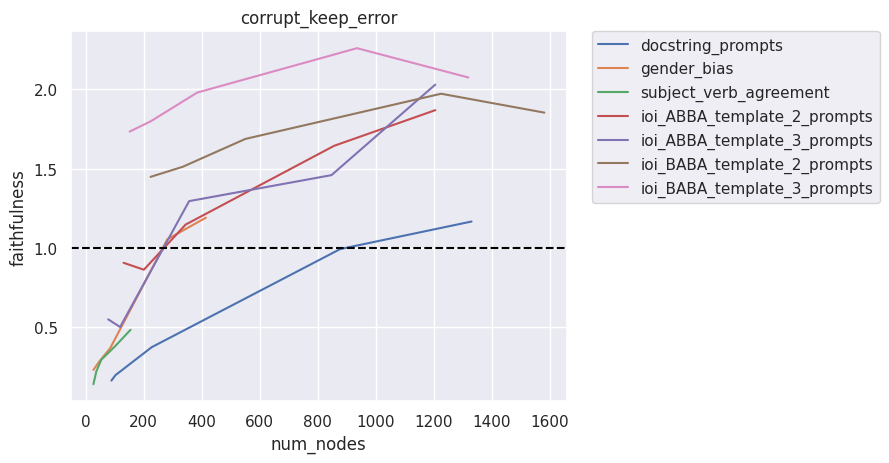

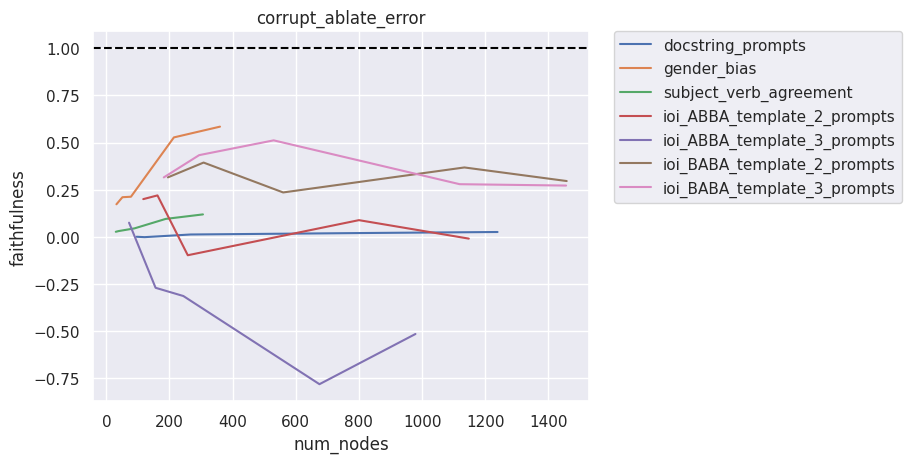

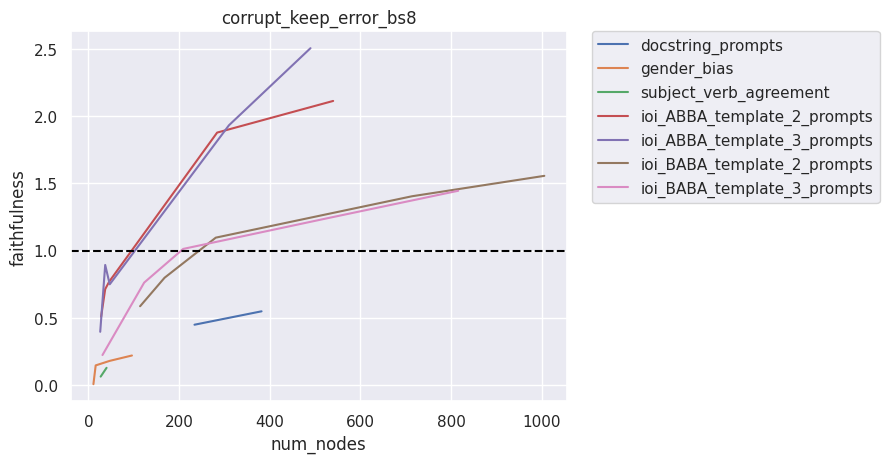

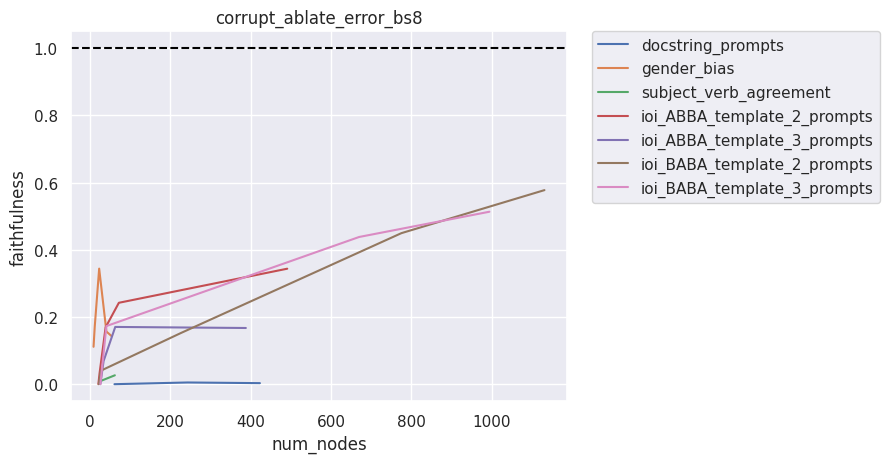

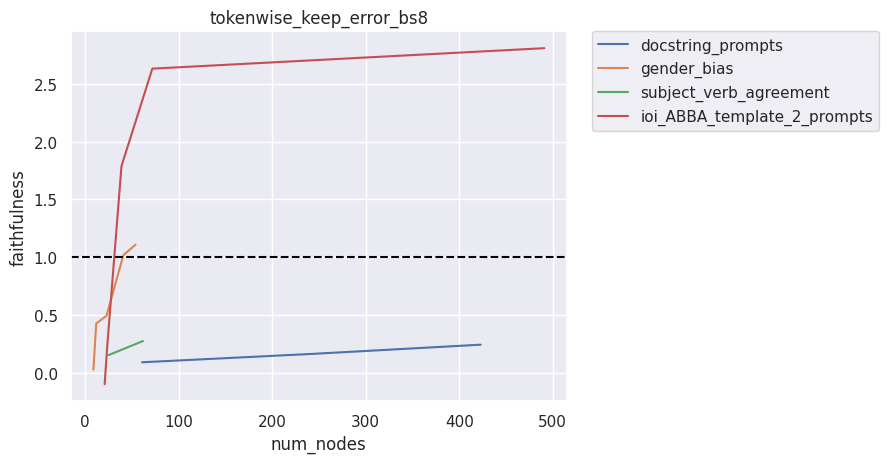

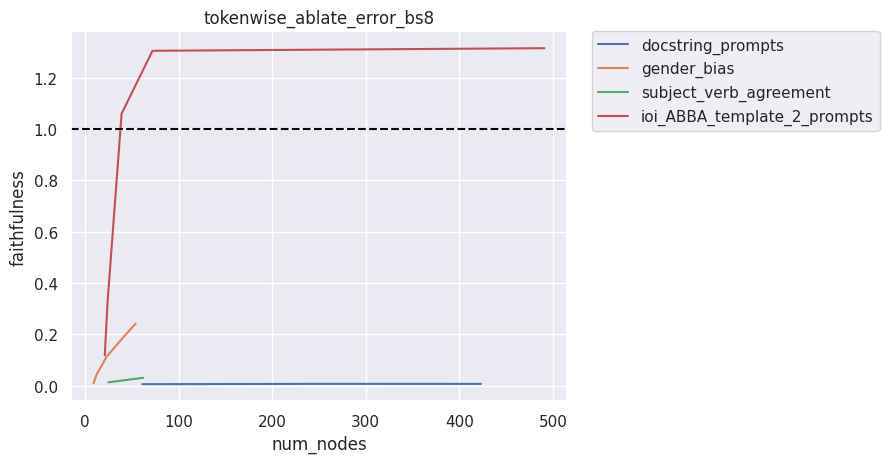

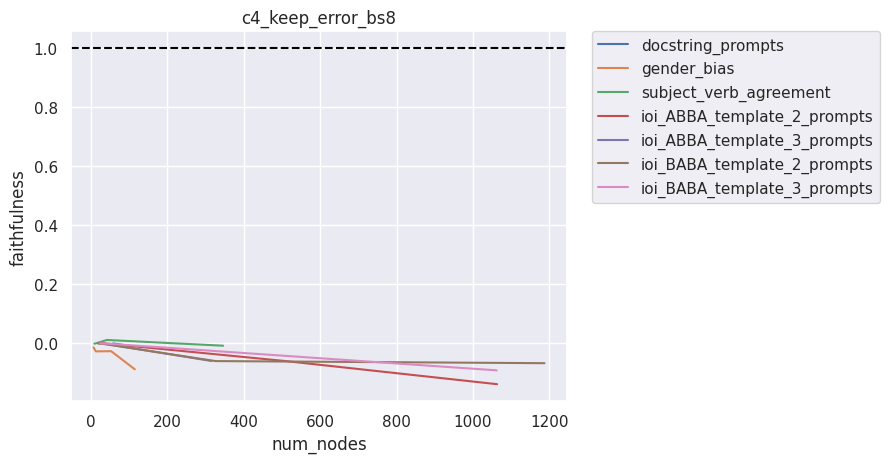

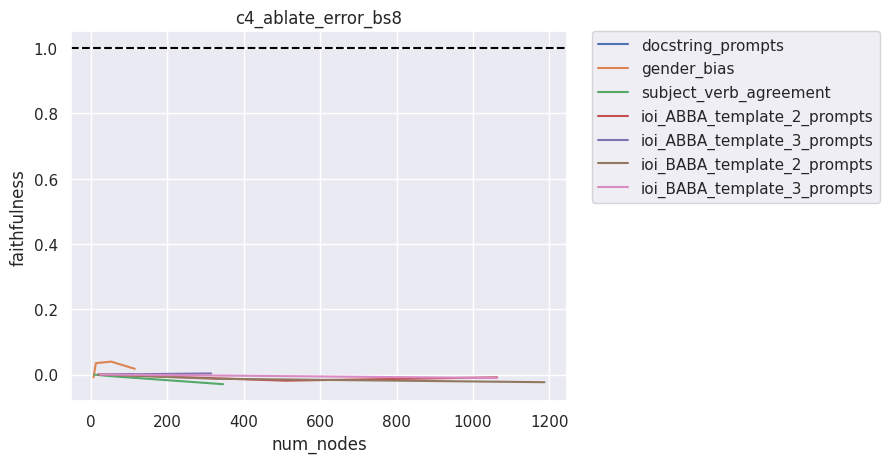

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

def make_plot_for_setting(df, sweep_name: str):
    fig, ax = plt.subplots()
    plot_df = df[(df.sweep_name == sweep_name)]
    sns.lineplot(data=plot_df, x="num_nodes", y="faithfulness", hue="dataset")
    ax.axhline(1, ls="--", color="black")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.title(sweep_name)

for sweep_name in SWEEP_NAMES:
    make_plot_for_setting(df, sweep_name)
